In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import cv2
from imutils import paths

# set the matplotlib backend so figures can be saved in the background
import matplotlib
matplotlib.use("Agg")

# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.pooling import AveragePooling2D
from keras.applications import ResNet50
from keras.layers.core import Dropout
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import SGD, Adam
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import cv2
import os

Using TensorFlow backend.


In [3]:
import pandas as pd
import numpy as np
from imutils import paths

In [8]:
path_to_data = '../Datasets/Images/FireSmokeDataset/'
imagePaths = list(paths.list_images(path_to_data))
N_size = len(imagePaths)

gt_info = pd.read_csv(path_to_data + 'labels.csv')

In [14]:
gt_info.loc[(gt_info.fire == 1) & (gt_info.smoke == 1)]

,Unnamed: 0,path,fire,smoke,normal
0,0,../Datasets/Images/Final/1.jpg,1,1,0
5,5,../Datasets/Images/Final/6.jpg,1,1,0
12,12,../Datasets/Images/Final/13.jpg,1,1,0
15,15,../Datasets/Images/Final/16.jpg,1,1,0
28,28,../Datasets/Images/Final/29.jpg,1,1,0
...,...,...,...,...,...
5519,5519,../Datasets/Images/Final/5520.jpg,1,1,0
5521,5521,../Datasets/Images/Final/5522.jpg,1,1,0
5535,5535,../Datasets/Images/Final/5536.jpg,1,1,0
5539,5539,../Datasets/Images/Final/5540.jpg,1,1,0


### Training

In [6]:
path_to_data = '../Datasets/Images/FireSmokeDataset/'
imagePaths = list(paths.list_images(path_to_data))
N_size = len(imagePaths)

gt_info = pd.read_csv(path_to_data + 'labels.csv')
data_list = []

for i in range(N_size):
    # load image
    imagePath = imagePaths[i]
    image = cv2.imread(imagePath)
    data_list.append(image)

In [7]:
data = np.array(data_list)
data_list.clear()
labels = gt_info[['fire', 'smoke', 'normal']].values
    
(trainX, testX, trainY, testY) = train_test_split(data, labels, 
                                                  test_size=0.25,
                                                  random_state=42)

In [19]:
trainAug = ImageDataGenerator(
    rotation_range=30,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest")

valAug = ImageDataGenerator()
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [20]:
# load the ResNet-50, disable head
baseModel = ResNet50(weights="imagenet", include_top=False, 
                     input_tensor=Input(shape=(224, 224, 3)))

/home/mk99/anaconda3/lib/python3.7/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 27s 0us/step


In [41]:
N_classes = 3

# constructing new head (sigmoid for multi-label)
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(N_classes, activation="sigmoid")(headModel)

# combined model
model = Model(inputs=baseModel.input, outputs=headModel)

# freeze all base layers
for layer in baseModel.layers:
    layer.trainable = False

In [ ]:
EPOCHS = 75
INIT_LR = 1e-3
BS = 32

print("[INFO] compiling model...")

#opt = SGD(lr=1e-4, momentum=0.9, decay=1e-4 / args["epochs"])
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# binary crossentropy - for multilabel
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

print("[INFO] training head...")
H = model.fit_generator(
    trainAug.flow(trainX, trainY, batch_size=BS),
    steps_per_epoch=len(trainX) // BS,
    validation_data=valAug.flow(testX, testY),
    validation_steps=len(testX) // BS,
    epochs=EPOCHS, verbose=1)

[INFO] compiling model...
[INFO] training head...


### Initial preprocessing

fire - 1, normal - 0

In [3]:
labels = []
new_paths = []

In [18]:
path_from = '../Datasets/Images/Smoke/'
#path_to = '../Datasets/Images/Processed/Fire/'

imagePaths = list(paths.list_images(path_from))

len(imagePaths)

1079

In [17]:
len(labels)

8964

### Create

In [19]:
path_from = '../Datasets/Images/Smoke/'
path_to = '../Datasets/Images/Processed/Fire/'

imagePaths = list(paths.list_images(path_from))

N_size = len(imagePaths)

name = len(labels)

for i in range(N_size):

    # load image
    imagePath = imagePaths[i]
    image = cv2.imread(imagePath)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    
    # save processed image
    new_image_path = path_to + '{}.jpg'.format(name + i)
    cv2.imwrite(new_image_path, image)
    
    # update the data and labels lists, respectively
    labels.append(1)
    new_paths.append(new_image_path)
    
print('Completed!')

Completed!


### Merge

In [64]:
path_from = '../Datasets/Images/ProcessedTwoFolders/'
path_to = '../Datasets/Images/ProcessedFireDataset/Images/'

imagePaths = list(paths.list_images(path_from))
N_size = len(imagePaths)


for i in range(N_size):
    
    imagePath = imagePaths[i]
    image = cv2.imread(imagePath)
    
    new_image_path = path_to + imagePath[imagePath.rfind('/') + 1:]
    cv2.imwrite(new_image_path, image)
    
print('Completed!')

Completed!


In [49]:
labels = np.array(labels)
new_paths = np.array(new_paths)

class_labels = pd.DataFrame({'path': new_paths, 'label': labels})

In [30]:
len('../Datasets/Images/Processed/Fire/')

34

In [50]:
class_labels['path'] = class_labels['path'].apply(lambda x: x[34:])
class_labels

,path,label
0,0.jpg,1
1,1.jpg,1
2,2.jpg,1
3,3.jpg,1
4,4.jpg,1
...,...,...
10038,10038.jpg,1
10039,10039.jpg,1
10040,10040.jpg,1
10041,10041.jpg,1


In [54]:
class_labels.to_csv('class_labels_10k.csv')

In [18]:
path_to_data = '../Datasets/Images/Mixed/3_5k/'

gt_info = pd.read_csv(path_to_data + 'imagenames-classes.csv', header=None)
gt_info.columns = pd.Series(['image_path', 'fire', 'smoke'])
#img = Image.open(path_to_data + '10010466715.jpg')
#img.show()
#pix = np.array(img)
#pix.shape
#cv2.imshow('image', image)
#cv2.waitKey(0)
#cv2.destroyAllWindows()

print("[INFO] loading images...")
imagePaths = list(paths.list_images(path_to_data))

N_size = len(imagePaths)
path_to_save = '../Datasets/Images/Final/'

new_paths = []
fire = []
smoke = []
normal = []

for i in range(N_size):
    
    # load labels
    is_fire = gt_info.loc[i, 'fire']
    is_smoke = gt_info.loc[i].smoke
    is_normal = int(is_fire == 0 and is_smoke == 0)
    label = [is_fire, is_smoke, is_normal]

    # load image
    imagePath = imagePaths[i]
    image = cv2.imread(imagePath)
    #image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image = cv2.resize(image, (224, 224))
    
    # save processed image
    new_image_path = path_to_save + '{}.jpg'.format(i + 1)
    cv2.imwrite(new_image_path, image)
    
    # update the data and labels lists, respectively
    fire.append(is_fire)
    smoke.append(is_smoke)
    normal.append(is_normal)
    new_paths.append(new_image_path)
    

proc_labels = pd.DataFrame({'path': new_paths, 'fire': fire, 
                            'smoke': smoke, 'normal': normal})
proc_labels.to_csv(path_to_save + 'labels.csv')

print('[INFO] Completed successfully!')

[INFO] loading images...
[INFO] Completed successfully!


In [10]:
import pandas as pd
import numpy as np
from PIL import Image
import cv2
from imutils import paths

In [4]:
labels_1 = pd.read_csv('../Datasets/Images/ProcessedFireDataset/class_labels_10k.csv')
labels_1.head()

,Unnamed: 0,path,label
0,0,0.jpg,1
1,1,1.jpg,1
2,2,2.jpg,1
3,3,3.jpg,1
4,4,4.jpg,1


In [11]:
labels_new = []
paths_new = []

In [13]:
path = '../Datasets/Images/Inferno/train/fire/'
path_to = '../Datasets/Images/AntiFire Dataset/Images/'

imagePaths = list(paths.list_images(path))
N_size = len(imagePaths)
start_name = 10043

for i in range(N_size):
    
    imagePath = imagePaths[i]
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (224, 224))
    
    new_image_path = path_to + '{}.jpg'.format(start_name + i)
    cv2.imwrite(new_image_path, image)
    
    labels_new.append(1)
    paths_new.append(new_image_path)
    
print('Completed!')

Completed!


In [14]:
path = '../Datasets/Images/Inferno/train/nonfire/'
path_to = '../Datasets/Images/AntiFire Dataset/Images/'

imagePaths = list(paths.list_images(path))
N_size = len(imagePaths)
start_name = 20165

for i in range(N_size):
    
    imagePath = imagePaths[i]
    image = cv2.imread(imagePath)
    image = cv2.resize(image, (224, 224))
    
    new_image_path = path_to + '{}.jpg'.format(start_name + i)
    cv2.imwrite(new_image_path, image)
    
    labels_new.append(0)
    paths_new.append(new_image_path)
    
print('Completed!')

KeyboardInterrupt: 

In [42]:
select_from = len(paths_new) - (33421 - 10043)
labels_new = labels_new[select_from:]
paths_new = paths_new[select_from:]

In [51]:
path_old = list(labels_1.path)
label_old = list(labels_1.label)

In [53]:
path_old.extend(paths_new)
label_old.extend(labels_new)

In [56]:
new_df = pd.DataFrame({'path': path_old, 'label': })

33421

In [2]:
import pandas as pd
import numpy as np
from PIL import Image
import cv2
from imutils import paths

In [3]:
path_from = '../Datasets/Images/ProcessedFireDataset/Images/'
path_fire = '../Datasets/Images/AntiFire Dataset Small/fire/'
path_normal = '../Datasets/Images/AntiFire Dataset Small/normal/'

In [4]:
labels = pd.read_csv('../Datasets/Images/ProcessedFireDataset/class_labels_10k.csv')
labels.head()

,Unnamed: 0,path,label
0,0,0.jpg,1
1,1,1.jpg,1
2,2,2.jpg,1
3,3,3.jpg,1
4,4,4.jpg,1


In [30]:
#fire_paths = []
normal_paths = []

In [31]:
#imagePaths = list(paths.list_images(path_from))
N_size = labels.shape[0]

for i in range(N_size):
    #image = cv2.imread(labels.iloc[i].path)
    path = labels.iloc[i].path
    if path.startswith('l/'):
        path = path[2:]
    #if not path.startswith('..'):
    #    path = '../Datasets/Images/AntiFire Dataset/Images/' + path
    if labels.iloc[i].label == 1:
        #fire_paths.append(path)
        pass
    else:
        normal_paths.append(path_from + path)
    
print('Completed!')

Completed!


In [26]:
#from sklearn.utils import shuffle

#fire_paths_shuffle = shuffle(fire_paths)

In [11]:
from sklearn.model_selection import train_test_split

train_fire, test_fire = train_test_split(fire_paths, shuffle=True, random_state=11, 
                                        test_size=0.25)

In [33]:
train_normal, test_normal = train_test_split(normal_paths, shuffle=True, random_state=11, 
                                        test_size=0.25)

In [14]:
'../Datasets/Images/AntiFire Dataset/Images/' + train_fire[1]

'../Datasets/Images/AntiFire Dataset/Images/1695.jpg'

In [32]:
train_fire[0]

'../Datasets/Images/AntiFire Dataset/Images/19607.jpg'

In [18]:
for i in range(N_size):
    path = '../Datasets/Images/AntiFire Dataset/Images/' + train_fire[i]
    print(path)
    image = cv2.imread(path)
    print(image)
    new_image_path = '../Datasets/Images/AntiFire Dataset/train/fire/' + \
                    'train_fire_{}.jpg'.format(0)
    train_fire_name += 1
    #cv2.imwrite(new_image_path, image)

../Datasets/Images/AntiFire Dataset/Images/../Datasets/Images/AntiFire Dataset/Images/19607.jpg
None


In [13]:
train_fire_name = 0

for i in range(len(train_fire)):
    image = cv2.imread(train_fire[i])
    new_image_path = '../Datasets/Images/AntiFire Dataset Small/train/fire/' + \
                    'train_fire_{}.jpg'.format(train_fire_name)
    train_fire_name += 1
    cv2.imwrite(new_image_path, image)

In [15]:
test_fire_name = 0

for i in range(len(test_fire)):
    image = cv2.imread(test_fire[i])
    new_image_path = '../Datasets/Images/AntiFire Dataset Small/test/fire/' + \
                    'test_fire_{}.jpg'.format(test_fire_name)
    test_fire_name += 1
    cv2.imwrite(new_image_path, image)

In [34]:
train_normal_name = 0

for i in range(len(train_normal)):
    image = cv2.imread(train_normal[i])
    print(train_normal[i])
    new_image_path = '../Datasets/Images/AntiFire Dataset Small/train/normal/' + \
                    'train_normal_{}.jpg'.format(train_normal_name)
    train_normal_name += 1
    cv2.imwrite(new_image_path, image)

../Datasets/Images/ProcessedFireDataset/Images/8326.jpg
../Datasets/Images/ProcessedFireDataset/Images/5572.jpg
../Datasets/Images/ProcessedFireDataset/Images/4867.jpg
../Datasets/Images/ProcessedFireDataset/Images/7678.jpg
../Datasets/Images/ProcessedFireDataset/Images/6005.jpg
../Datasets/Images/ProcessedFireDataset/Images/4735.jpg
../Datasets/Images/ProcessedFireDataset/Images/4445.jpg
../Datasets/Images/ProcessedFireDataset/Images/5096.jpg
../Datasets/Images/ProcessedFireDataset/Images/6201.jpg
../Datasets/Images/ProcessedFireDataset/Images/7628.jpg
../Datasets/Images/ProcessedFireDataset/Images/6936.jpg
../Datasets/Images/ProcessedFireDataset/Images/6214.jpg
../Datasets/Images/ProcessedFireDataset/Images/4475.jpg
../Datasets/Images/ProcessedFireDataset/Images/8292.jpg
../Datasets/Images/ProcessedFireDataset/Images/6634.jpg
../Datasets/Images/ProcessedFireDataset/Images/8405.jpg
../Datasets/Images/ProcessedFireDataset/Images/8516.jpg
../Datasets/Images/ProcessedFireDataset/Images/5

../Datasets/Images/ProcessedFireDataset/Images/8232.jpg
../Datasets/Images/ProcessedFireDataset/Images/8102.jpg
../Datasets/Images/ProcessedFireDataset/Images/6172.jpg
../Datasets/Images/ProcessedFireDataset/Images/6707.jpg
../Datasets/Images/ProcessedFireDataset/Images/8810.jpg
../Datasets/Images/ProcessedFireDataset/Images/6808.jpg
../Datasets/Images/ProcessedFireDataset/Images/7147.jpg
../Datasets/Images/ProcessedFireDataset/Images/8639.jpg
../Datasets/Images/ProcessedFireDataset/Images/4197.jpg
../Datasets/Images/ProcessedFireDataset/Images/7163.jpg
../Datasets/Images/ProcessedFireDataset/Images/6371.jpg
../Datasets/Images/ProcessedFireDataset/Images/4217.jpg
../Datasets/Images/ProcessedFireDataset/Images/5536.jpg
../Datasets/Images/ProcessedFireDataset/Images/5200.jpg
../Datasets/Images/ProcessedFireDataset/Images/7302.jpg
../Datasets/Images/ProcessedFireDataset/Images/5323.jpg
../Datasets/Images/ProcessedFireDataset/Images/6459.jpg
../Datasets/Images/ProcessedFireDataset/Images/7

../Datasets/Images/ProcessedFireDataset/Images/5041.jpg
../Datasets/Images/ProcessedFireDataset/Images/7437.jpg
../Datasets/Images/ProcessedFireDataset/Images/5334.jpg
../Datasets/Images/ProcessedFireDataset/Images/5263.jpg
../Datasets/Images/ProcessedFireDataset/Images/4840.jpg
../Datasets/Images/ProcessedFireDataset/Images/4494.jpg
../Datasets/Images/ProcessedFireDataset/Images/5054.jpg
../Datasets/Images/ProcessedFireDataset/Images/8854.jpg
../Datasets/Images/ProcessedFireDataset/Images/8209.jpg
../Datasets/Images/ProcessedFireDataset/Images/5180.jpg
../Datasets/Images/ProcessedFireDataset/Images/8254.jpg
../Datasets/Images/ProcessedFireDataset/Images/4458.jpg
../Datasets/Images/ProcessedFireDataset/Images/5621.jpg
../Datasets/Images/ProcessedFireDataset/Images/6422.jpg
../Datasets/Images/ProcessedFireDataset/Images/5419.jpg
../Datasets/Images/ProcessedFireDataset/Images/4207.jpg
../Datasets/Images/ProcessedFireDataset/Images/4910.jpg
../Datasets/Images/ProcessedFireDataset/Images/6

../Datasets/Images/ProcessedFireDataset/Images/6477.jpg
../Datasets/Images/ProcessedFireDataset/Images/5518.jpg
../Datasets/Images/ProcessedFireDataset/Images/8812.jpg
../Datasets/Images/ProcessedFireDataset/Images/6381.jpg
../Datasets/Images/ProcessedFireDataset/Images/6932.jpg
../Datasets/Images/ProcessedFireDataset/Images/6864.jpg
../Datasets/Images/ProcessedFireDataset/Images/7482.jpg
../Datasets/Images/ProcessedFireDataset/Images/6559.jpg
../Datasets/Images/ProcessedFireDataset/Images/7931.jpg
../Datasets/Images/ProcessedFireDataset/Images/8401.jpg
../Datasets/Images/ProcessedFireDataset/Images/8797.jpg
../Datasets/Images/ProcessedFireDataset/Images/5521.jpg
../Datasets/Images/ProcessedFireDataset/Images/7782.jpg
../Datasets/Images/ProcessedFireDataset/Images/4280.jpg
../Datasets/Images/ProcessedFireDataset/Images/8313.jpg
../Datasets/Images/ProcessedFireDataset/Images/4937.jpg
../Datasets/Images/ProcessedFireDataset/Images/8816.jpg
../Datasets/Images/ProcessedFireDataset/Images/4

../Datasets/Images/ProcessedFireDataset/Images/6418.jpg
../Datasets/Images/ProcessedFireDataset/Images/5159.jpg
../Datasets/Images/ProcessedFireDataset/Images/8610.jpg
../Datasets/Images/ProcessedFireDataset/Images/4664.jpg
../Datasets/Images/ProcessedFireDataset/Images/7672.jpg
../Datasets/Images/ProcessedFireDataset/Images/8465.jpg
../Datasets/Images/ProcessedFireDataset/Images/5717.jpg
../Datasets/Images/ProcessedFireDataset/Images/6981.jpg
../Datasets/Images/ProcessedFireDataset/Images/7181.jpg
../Datasets/Images/ProcessedFireDataset/Images/5402.jpg
../Datasets/Images/ProcessedFireDataset/Images/7440.jpg
../Datasets/Images/ProcessedFireDataset/Images/4334.jpg
../Datasets/Images/ProcessedFireDataset/Images/6565.jpg
../Datasets/Images/ProcessedFireDataset/Images/4823.jpg
../Datasets/Images/ProcessedFireDataset/Images/5485.jpg
../Datasets/Images/ProcessedFireDataset/Images/8760.jpg
../Datasets/Images/ProcessedFireDataset/Images/4810.jpg
../Datasets/Images/ProcessedFireDataset/Images/7

../Datasets/Images/ProcessedFireDataset/Images/8245.jpg
../Datasets/Images/ProcessedFireDataset/Images/8927.jpg
../Datasets/Images/ProcessedFireDataset/Images/6147.jpg
../Datasets/Images/ProcessedFireDataset/Images/5215.jpg
../Datasets/Images/ProcessedFireDataset/Images/7919.jpg
../Datasets/Images/ProcessedFireDataset/Images/8372.jpg
../Datasets/Images/ProcessedFireDataset/Images/5113.jpg
../Datasets/Images/ProcessedFireDataset/Images/6390.jpg
../Datasets/Images/ProcessedFireDataset/Images/7341.jpg
../Datasets/Images/ProcessedFireDataset/Images/6667.jpg
../Datasets/Images/ProcessedFireDataset/Images/8371.jpg
../Datasets/Images/ProcessedFireDataset/Images/7840.jpg
../Datasets/Images/ProcessedFireDataset/Images/8289.jpg
../Datasets/Images/ProcessedFireDataset/Images/6217.jpg
../Datasets/Images/ProcessedFireDataset/Images/7542.jpg
../Datasets/Images/ProcessedFireDataset/Images/7143.jpg
../Datasets/Images/ProcessedFireDataset/Images/8272.jpg
../Datasets/Images/ProcessedFireDataset/Images/6

../Datasets/Images/ProcessedFireDataset/Images/7851.jpg
../Datasets/Images/ProcessedFireDataset/Images/8785.jpg
../Datasets/Images/ProcessedFireDataset/Images/5185.jpg
../Datasets/Images/ProcessedFireDataset/Images/5846.jpg
../Datasets/Images/ProcessedFireDataset/Images/6846.jpg
../Datasets/Images/ProcessedFireDataset/Images/6428.jpg
../Datasets/Images/ProcessedFireDataset/Images/6754.jpg
../Datasets/Images/ProcessedFireDataset/Images/7477.jpg
../Datasets/Images/ProcessedFireDataset/Images/4177.jpg
../Datasets/Images/ProcessedFireDataset/Images/5566.jpg
../Datasets/Images/ProcessedFireDataset/Images/8597.jpg
../Datasets/Images/ProcessedFireDataset/Images/4472.jpg
../Datasets/Images/ProcessedFireDataset/Images/6465.jpg
../Datasets/Images/ProcessedFireDataset/Images/6859.jpg
../Datasets/Images/ProcessedFireDataset/Images/5149.jpg
../Datasets/Images/ProcessedFireDataset/Images/8263.jpg
../Datasets/Images/ProcessedFireDataset/Images/5834.jpg
../Datasets/Images/ProcessedFireDataset/Images/4

../Datasets/Images/ProcessedFireDataset/Images/8340.jpg
../Datasets/Images/ProcessedFireDataset/Images/8086.jpg
../Datasets/Images/ProcessedFireDataset/Images/4234.jpg
../Datasets/Images/ProcessedFireDataset/Images/4783.jpg
../Datasets/Images/ProcessedFireDataset/Images/5986.jpg
../Datasets/Images/ProcessedFireDataset/Images/7069.jpg
../Datasets/Images/ProcessedFireDataset/Images/4679.jpg
../Datasets/Images/ProcessedFireDataset/Images/7534.jpg
../Datasets/Images/ProcessedFireDataset/Images/7595.jpg
../Datasets/Images/ProcessedFireDataset/Images/5201.jpg
../Datasets/Images/ProcessedFireDataset/Images/6480.jpg
../Datasets/Images/ProcessedFireDataset/Images/8426.jpg
../Datasets/Images/ProcessedFireDataset/Images/4440.jpg
../Datasets/Images/ProcessedFireDataset/Images/8202.jpg
../Datasets/Images/ProcessedFireDataset/Images/5128.jpg
../Datasets/Images/ProcessedFireDataset/Images/8566.jpg
../Datasets/Images/ProcessedFireDataset/Images/7955.jpg
../Datasets/Images/ProcessedFireDataset/Images/6

../Datasets/Images/ProcessedFireDataset/Images/8415.jpg
../Datasets/Images/ProcessedFireDataset/Images/5709.jpg
../Datasets/Images/ProcessedFireDataset/Images/7668.jpg
../Datasets/Images/ProcessedFireDataset/Images/6216.jpg
../Datasets/Images/ProcessedFireDataset/Images/6616.jpg
../Datasets/Images/ProcessedFireDataset/Images/7035.jpg
../Datasets/Images/ProcessedFireDataset/Images/7258.jpg
../Datasets/Images/ProcessedFireDataset/Images/6510.jpg
../Datasets/Images/ProcessedFireDataset/Images/5000.jpg
../Datasets/Images/ProcessedFireDataset/Images/4396.jpg
../Datasets/Images/ProcessedFireDataset/Images/6695.jpg
../Datasets/Images/ProcessedFireDataset/Images/5612.jpg
../Datasets/Images/ProcessedFireDataset/Images/7257.jpg
../Datasets/Images/ProcessedFireDataset/Images/5328.jpg
../Datasets/Images/ProcessedFireDataset/Images/8470.jpg
../Datasets/Images/ProcessedFireDataset/Images/6977.jpg
../Datasets/Images/ProcessedFireDataset/Images/6295.jpg
../Datasets/Images/ProcessedFireDataset/Images/8

../Datasets/Images/ProcessedFireDataset/Images/5545.jpg
../Datasets/Images/ProcessedFireDataset/Images/5327.jpg
../Datasets/Images/ProcessedFireDataset/Images/5570.jpg
../Datasets/Images/ProcessedFireDataset/Images/5662.jpg
../Datasets/Images/ProcessedFireDataset/Images/6012.jpg
../Datasets/Images/ProcessedFireDataset/Images/8698.jpg
../Datasets/Images/ProcessedFireDataset/Images/5086.jpg
../Datasets/Images/ProcessedFireDataset/Images/8741.jpg
../Datasets/Images/ProcessedFireDataset/Images/6313.jpg
../Datasets/Images/ProcessedFireDataset/Images/5306.jpg
../Datasets/Images/ProcessedFireDataset/Images/7083.jpg
../Datasets/Images/ProcessedFireDataset/Images/6352.jpg
../Datasets/Images/ProcessedFireDataset/Images/7262.jpg
../Datasets/Images/ProcessedFireDataset/Images/8899.jpg
../Datasets/Images/ProcessedFireDataset/Images/5786.jpg
../Datasets/Images/ProcessedFireDataset/Images/8237.jpg
../Datasets/Images/ProcessedFireDataset/Images/7402.jpg
../Datasets/Images/ProcessedFireDataset/Images/6

../Datasets/Images/ProcessedFireDataset/Images/6258.jpg
../Datasets/Images/ProcessedFireDataset/Images/8747.jpg
../Datasets/Images/ProcessedFireDataset/Images/4299.jpg
../Datasets/Images/ProcessedFireDataset/Images/5537.jpg
../Datasets/Images/ProcessedFireDataset/Images/5229.jpg
../Datasets/Images/ProcessedFireDataset/Images/5488.jpg
../Datasets/Images/ProcessedFireDataset/Images/7276.jpg
../Datasets/Images/ProcessedFireDataset/Images/6575.jpg
../Datasets/Images/ProcessedFireDataset/Images/5416.jpg
../Datasets/Images/ProcessedFireDataset/Images/5246.jpg
../Datasets/Images/ProcessedFireDataset/Images/4181.jpg
../Datasets/Images/ProcessedFireDataset/Images/8546.jpg
../Datasets/Images/ProcessedFireDataset/Images/4231.jpg
../Datasets/Images/ProcessedFireDataset/Images/6236.jpg
../Datasets/Images/ProcessedFireDataset/Images/8596.jpg
../Datasets/Images/ProcessedFireDataset/Images/7494.jpg
../Datasets/Images/ProcessedFireDataset/Images/5810.jpg
../Datasets/Images/ProcessedFireDataset/Images/7

../Datasets/Images/ProcessedFireDataset/Images/8011.jpg
../Datasets/Images/ProcessedFireDataset/Images/8474.jpg
../Datasets/Images/ProcessedFireDataset/Images/4753.jpg
../Datasets/Images/ProcessedFireDataset/Images/8628.jpg
../Datasets/Images/ProcessedFireDataset/Images/6356.jpg
../Datasets/Images/ProcessedFireDataset/Images/6443.jpg
../Datasets/Images/ProcessedFireDataset/Images/5255.jpg
../Datasets/Images/ProcessedFireDataset/Images/7740.jpg
../Datasets/Images/ProcessedFireDataset/Images/7875.jpg
../Datasets/Images/ProcessedFireDataset/Images/4382.jpg
../Datasets/Images/ProcessedFireDataset/Images/6941.jpg
../Datasets/Images/ProcessedFireDataset/Images/4871.jpg
../Datasets/Images/ProcessedFireDataset/Images/5701.jpg
../Datasets/Images/ProcessedFireDataset/Images/5595.jpg
../Datasets/Images/ProcessedFireDataset/Images/7214.jpg
../Datasets/Images/ProcessedFireDataset/Images/7410.jpg
../Datasets/Images/ProcessedFireDataset/Images/4989.jpg
../Datasets/Images/ProcessedFireDataset/Images/6

../Datasets/Images/ProcessedFireDataset/Images/6344.jpg
../Datasets/Images/ProcessedFireDataset/Images/7109.jpg
../Datasets/Images/ProcessedFireDataset/Images/8466.jpg
../Datasets/Images/ProcessedFireDataset/Images/7659.jpg
../Datasets/Images/ProcessedFireDataset/Images/8475.jpg
../Datasets/Images/ProcessedFireDataset/Images/8687.jpg
../Datasets/Images/ProcessedFireDataset/Images/5973.jpg
../Datasets/Images/ProcessedFireDataset/Images/7738.jpg
../Datasets/Images/ProcessedFireDataset/Images/7759.jpg
../Datasets/Images/ProcessedFireDataset/Images/6273.jpg
../Datasets/Images/ProcessedFireDataset/Images/4333.jpg
../Datasets/Images/ProcessedFireDataset/Images/4736.jpg
../Datasets/Images/ProcessedFireDataset/Images/6945.jpg
../Datasets/Images/ProcessedFireDataset/Images/5065.jpg
../Datasets/Images/ProcessedFireDataset/Images/5107.jpg
../Datasets/Images/ProcessedFireDataset/Images/5943.jpg
../Datasets/Images/ProcessedFireDataset/Images/5245.jpg
../Datasets/Images/ProcessedFireDataset/Images/7

../Datasets/Images/ProcessedFireDataset/Images/7405.jpg
../Datasets/Images/ProcessedFireDataset/Images/6531.jpg
../Datasets/Images/ProcessedFireDataset/Images/5081.jpg
../Datasets/Images/ProcessedFireDataset/Images/5935.jpg
../Datasets/Images/ProcessedFireDataset/Images/5082.jpg
../Datasets/Images/ProcessedFireDataset/Images/4232.jpg
../Datasets/Images/ProcessedFireDataset/Images/8554.jpg
../Datasets/Images/ProcessedFireDataset/Images/4663.jpg
../Datasets/Images/ProcessedFireDataset/Images/6478.jpg
../Datasets/Images/ProcessedFireDataset/Images/5322.jpg
../Datasets/Images/ProcessedFireDataset/Images/5057.jpg
../Datasets/Images/ProcessedFireDataset/Images/7665.jpg
../Datasets/Images/ProcessedFireDataset/Images/7843.jpg
../Datasets/Images/ProcessedFireDataset/Images/7620.jpg
../Datasets/Images/ProcessedFireDataset/Images/4876.jpg
../Datasets/Images/ProcessedFireDataset/Images/7351.jpg
../Datasets/Images/ProcessedFireDataset/Images/6348.jpg
../Datasets/Images/ProcessedFireDataset/Images/5

../Datasets/Images/ProcessedFireDataset/Images/8627.jpg
../Datasets/Images/ProcessedFireDataset/Images/8631.jpg
../Datasets/Images/ProcessedFireDataset/Images/4464.jpg
../Datasets/Images/ProcessedFireDataset/Images/7140.jpg
../Datasets/Images/ProcessedFireDataset/Images/5321.jpg
../Datasets/Images/ProcessedFireDataset/Images/4703.jpg
../Datasets/Images/ProcessedFireDataset/Images/6466.jpg
../Datasets/Images/ProcessedFireDataset/Images/4768.jpg
../Datasets/Images/ProcessedFireDataset/Images/8264.jpg
../Datasets/Images/ProcessedFireDataset/Images/4585.jpg
../Datasets/Images/ProcessedFireDataset/Images/5643.jpg
../Datasets/Images/ProcessedFireDataset/Images/8692.jpg
../Datasets/Images/ProcessedFireDataset/Images/8311.jpg
../Datasets/Images/ProcessedFireDataset/Images/4761.jpg
../Datasets/Images/ProcessedFireDataset/Images/7898.jpg
../Datasets/Images/ProcessedFireDataset/Images/5146.jpg
../Datasets/Images/ProcessedFireDataset/Images/6585.jpg
../Datasets/Images/ProcessedFireDataset/Images/4

../Datasets/Images/ProcessedFireDataset/Images/4420.jpg
../Datasets/Images/ProcessedFireDataset/Images/4908.jpg
../Datasets/Images/ProcessedFireDataset/Images/4938.jpg
../Datasets/Images/ProcessedFireDataset/Images/4455.jpg
../Datasets/Images/ProcessedFireDataset/Images/5383.jpg
../Datasets/Images/ProcessedFireDataset/Images/4428.jpg
../Datasets/Images/ProcessedFireDataset/Images/4724.jpg
../Datasets/Images/ProcessedFireDataset/Images/7985.jpg
../Datasets/Images/ProcessedFireDataset/Images/5424.jpg
../Datasets/Images/ProcessedFireDataset/Images/5636.jpg
../Datasets/Images/ProcessedFireDataset/Images/7071.jpg
../Datasets/Images/ProcessedFireDataset/Images/5933.jpg
../Datasets/Images/ProcessedFireDataset/Images/5397.jpg
../Datasets/Images/ProcessedFireDataset/Images/5816.jpg
../Datasets/Images/ProcessedFireDataset/Images/8144.jpg
../Datasets/Images/ProcessedFireDataset/Images/4568.jpg
../Datasets/Images/ProcessedFireDataset/Images/8625.jpg
../Datasets/Images/ProcessedFireDataset/Images/7

../Datasets/Images/ProcessedFireDataset/Images/4874.jpg
../Datasets/Images/ProcessedFireDataset/Images/8134.jpg
../Datasets/Images/ProcessedFireDataset/Images/5605.jpg
../Datasets/Images/ProcessedFireDataset/Images/5689.jpg
../Datasets/Images/ProcessedFireDataset/Images/8701.jpg
../Datasets/Images/ProcessedFireDataset/Images/7788.jpg
../Datasets/Images/ProcessedFireDataset/Images/4191.jpg
../Datasets/Images/ProcessedFireDataset/Images/5330.jpg
../Datasets/Images/ProcessedFireDataset/Images/5069.jpg
../Datasets/Images/ProcessedFireDataset/Images/8097.jpg
../Datasets/Images/ProcessedFireDataset/Images/4322.jpg
../Datasets/Images/ProcessedFireDataset/Images/4692.jpg
../Datasets/Images/ProcessedFireDataset/Images/8636.jpg
../Datasets/Images/ProcessedFireDataset/Images/4597.jpg
../Datasets/Images/ProcessedFireDataset/Images/8220.jpg
../Datasets/Images/ProcessedFireDataset/Images/8749.jpg
../Datasets/Images/ProcessedFireDataset/Images/8322.jpg
../Datasets/Images/ProcessedFireDataset/Images/7

../Datasets/Images/ProcessedFireDataset/Images/5820.jpg
../Datasets/Images/ProcessedFireDataset/Images/5063.jpg
../Datasets/Images/ProcessedFireDataset/Images/7547.jpg
../Datasets/Images/ProcessedFireDataset/Images/7234.jpg
../Datasets/Images/ProcessedFireDataset/Images/6814.jpg
../Datasets/Images/ProcessedFireDataset/Images/8456.jpg
../Datasets/Images/ProcessedFireDataset/Images/4950.jpg
../Datasets/Images/ProcessedFireDataset/Images/4992.jpg
../Datasets/Images/ProcessedFireDataset/Images/4314.jpg
../Datasets/Images/ProcessedFireDataset/Images/4804.jpg
../Datasets/Images/ProcessedFireDataset/Images/4809.jpg
../Datasets/Images/ProcessedFireDataset/Images/4224.jpg
../Datasets/Images/ProcessedFireDataset/Images/8693.jpg
../Datasets/Images/ProcessedFireDataset/Images/6081.jpg
../Datasets/Images/ProcessedFireDataset/Images/7546.jpg
../Datasets/Images/ProcessedFireDataset/Images/7037.jpg
../Datasets/Images/ProcessedFireDataset/Images/4644.jpg
../Datasets/Images/ProcessedFireDataset/Images/5

../Datasets/Images/ProcessedFireDataset/Images/8748.jpg
../Datasets/Images/ProcessedFireDataset/Images/5033.jpg
../Datasets/Images/ProcessedFireDataset/Images/8831.jpg
../Datasets/Images/ProcessedFireDataset/Images/5286.jpg
../Datasets/Images/ProcessedFireDataset/Images/8676.jpg
../Datasets/Images/ProcessedFireDataset/Images/7299.jpg
../Datasets/Images/ProcessedFireDataset/Images/6580.jpg
../Datasets/Images/ProcessedFireDataset/Images/4920.jpg
../Datasets/Images/ProcessedFireDataset/Images/6529.jpg
../Datasets/Images/ProcessedFireDataset/Images/4658.jpg
../Datasets/Images/ProcessedFireDataset/Images/8745.jpg
../Datasets/Images/ProcessedFireDataset/Images/4556.jpg
../Datasets/Images/ProcessedFireDataset/Images/8423.jpg
../Datasets/Images/ProcessedFireDataset/Images/6922.jpg
../Datasets/Images/ProcessedFireDataset/Images/7498.jpg
../Datasets/Images/ProcessedFireDataset/Images/7070.jpg
../Datasets/Images/ProcessedFireDataset/Images/8900.jpg
../Datasets/Images/ProcessedFireDataset/Images/6

../Datasets/Images/ProcessedFireDataset/Images/7544.jpg
../Datasets/Images/ProcessedFireDataset/Images/8425.jpg
../Datasets/Images/ProcessedFireDataset/Images/4474.jpg
../Datasets/Images/ProcessedFireDataset/Images/4856.jpg
../Datasets/Images/ProcessedFireDataset/Images/7757.jpg
../Datasets/Images/ProcessedFireDataset/Images/6268.jpg
../Datasets/Images/ProcessedFireDataset/Images/7787.jpg
../Datasets/Images/ProcessedFireDataset/Images/6360.jpg
../Datasets/Images/ProcessedFireDataset/Images/6768.jpg
../Datasets/Images/ProcessedFireDataset/Images/7282.jpg
../Datasets/Images/ProcessedFireDataset/Images/7780.jpg
../Datasets/Images/ProcessedFireDataset/Images/8704.jpg
../Datasets/Images/ProcessedFireDataset/Images/4380.jpg
../Datasets/Images/ProcessedFireDataset/Images/6007.jpg
../Datasets/Images/ProcessedFireDataset/Images/7098.jpg
../Datasets/Images/ProcessedFireDataset/Images/7489.jpg
../Datasets/Images/ProcessedFireDataset/Images/6083.jpg
../Datasets/Images/ProcessedFireDataset/Images/4

../Datasets/Images/ProcessedFireDataset/Images/7963.jpg
../Datasets/Images/ProcessedFireDataset/Images/6369.jpg
../Datasets/Images/ProcessedFireDataset/Images/8319.jpg
../Datasets/Images/ProcessedFireDataset/Images/5194.jpg
../Datasets/Images/ProcessedFireDataset/Images/5703.jpg
../Datasets/Images/ProcessedFireDataset/Images/4227.jpg
../Datasets/Images/ProcessedFireDataset/Images/4773.jpg
../Datasets/Images/ProcessedFireDataset/Images/5930.jpg
../Datasets/Images/ProcessedFireDataset/Images/6270.jpg
../Datasets/Images/ProcessedFireDataset/Images/7933.jpg
../Datasets/Images/ProcessedFireDataset/Images/7548.jpg
../Datasets/Images/ProcessedFireDataset/Images/4574.jpg
../Datasets/Images/ProcessedFireDataset/Images/7081.jpg
../Datasets/Images/ProcessedFireDataset/Images/4643.jpg
../Datasets/Images/ProcessedFireDataset/Images/5188.jpg
../Datasets/Images/ProcessedFireDataset/Images/7844.jpg
../Datasets/Images/ProcessedFireDataset/Images/8271.jpg
../Datasets/Images/ProcessedFireDataset/Images/4

../Datasets/Images/ProcessedFireDataset/Images/4589.jpg
../Datasets/Images/ProcessedFireDataset/Images/4513.jpg
../Datasets/Images/ProcessedFireDataset/Images/6709.jpg
../Datasets/Images/ProcessedFireDataset/Images/7275.jpg
../Datasets/Images/ProcessedFireDataset/Images/5264.jpg
../Datasets/Images/ProcessedFireDataset/Images/7097.jpg
../Datasets/Images/ProcessedFireDataset/Images/7568.jpg
../Datasets/Images/ProcessedFireDataset/Images/7066.jpg
../Datasets/Images/ProcessedFireDataset/Images/5102.jpg
../Datasets/Images/ProcessedFireDataset/Images/6070.jpg
../Datasets/Images/ProcessedFireDataset/Images/8430.jpg
../Datasets/Images/ProcessedFireDataset/Images/8853.jpg
../Datasets/Images/ProcessedFireDataset/Images/6409.jpg
../Datasets/Images/ProcessedFireDataset/Images/8515.jpg
../Datasets/Images/ProcessedFireDataset/Images/7614.jpg
../Datasets/Images/ProcessedFireDataset/Images/6380.jpg
../Datasets/Images/ProcessedFireDataset/Images/8246.jpg
../Datasets/Images/ProcessedFireDataset/Images/7

../Datasets/Images/ProcessedFireDataset/Images/7204.jpg
../Datasets/Images/ProcessedFireDataset/Images/4416.jpg
../Datasets/Images/ProcessedFireDataset/Images/4704.jpg
../Datasets/Images/ProcessedFireDataset/Images/8614.jpg
../Datasets/Images/ProcessedFireDataset/Images/5355.jpg
../Datasets/Images/ProcessedFireDataset/Images/5617.jpg
../Datasets/Images/ProcessedFireDataset/Images/5947.jpg
../Datasets/Images/ProcessedFireDataset/Images/8897.jpg
../Datasets/Images/ProcessedFireDataset/Images/7793.jpg
../Datasets/Images/ProcessedFireDataset/Images/4681.jpg
../Datasets/Images/ProcessedFireDataset/Images/8411.jpg
../Datasets/Images/ProcessedFireDataset/Images/5754.jpg
../Datasets/Images/ProcessedFireDataset/Images/8132.jpg
../Datasets/Images/ProcessedFireDataset/Images/8335.jpg
../Datasets/Images/ProcessedFireDataset/Images/6233.jpg
../Datasets/Images/ProcessedFireDataset/Images/5926.jpg
../Datasets/Images/ProcessedFireDataset/Images/6180.jpg
../Datasets/Images/ProcessedFireDataset/Images/7

In [35]:
test_normal_name = 0

for i in range(len(test_normal)):
    image = cv2.imread(test_normal[i])
    new_image_path = '../Datasets/Images/AntiFire Dataset Small/test/normal/' + \
                    'test_normal_{}.jpg'.format(test_normal_name)
    test_normal_name += 1
    cv2.imwrite(new_image_path, image)

In [ ]:
# saved


imagePaths = list(paths.list_images(path_from))
N_size = len(imagePaths)

fire_name = 0
normal_name = 0

for i in range(N_size):
    
    imagePath = imagePaths[i]
    image = cv2.imread(imagePath)
    
    if labels.iloc[i].label == 1:
        new_image_path = path_fire + 'fire_{}.jpg'.format(fire_name)
        fire_name += 1
    else:
        new_image_path = path_normal + 'normal_{}.jpg'.format(normal_name)
        normal_name += 1
    
    cv2.imwrite(new_image_path, image)
    
print('Completed!')

Mean and std

In [2]:
import numpy as np
import pandas as pd
import numpy as np
from PIL import Image
import cv2
from imutils import paths
from matplotlib import pyplot as plt

path_from = '../Datasets/Images/AntiFire Dataset Small/'

imagePaths = list(paths.list_images(path_from))
N_size = len(imagePaths)

In [9]:
mean = np.zeros((224, 224, 3), dtype=float)

for i in range(1000):
    
    imagePath = imagePaths[i]
    image = cv2.imread(imagePath)
    mean += image / 1000
    
print('Completed!')

Completed!


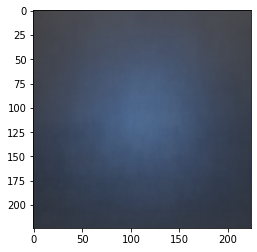

In [10]:
plt.imshow(mean.astype(int))

In [14]:
with open('mean.npy', 'wb') as file:
    np.save(file, mean)

In [17]:
std = np.zeros((224, 224, 3), dtype=float)

for i in range(1000):
    
    imagePath = imagePaths[i]
    image = cv2.imread(imagePath)
    std += (image - mean)**2 / 1000
    
std = np.sqrt(std)
    
print('Completed!')

Completed!


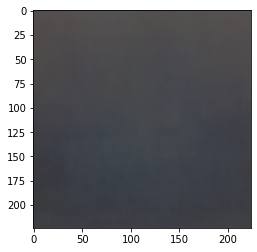

In [18]:
plt.imshow(std.astype(int))

In [19]:
with open('std.npy', 'wb') as file:
    np.save(file, std)

In [34]:
import numpy as np

In [69]:
arr = np.array([[np.array(['crop1_obj1_1', 'crop1_obj1_2']),np.array(['crop1_obj2_1', 'crop1_obj2_2'])], \
                [np.array(['crop2_obj1_1', 'crop2_obj1_2']),np.array(['crop2_obj2_1', 'crop2_obj2_2'])]])
np.hstack(arr).T

array([['crop1_obj1_1', 'crop1_obj2_1'],
       ['crop1_obj1_2', 'crop1_obj2_2'],
       ['crop2_obj1_1', 'crop2_obj2_1'],
       ['crop2_obj1_2', 'crop2_obj2_2']], dtype='<U12')